<h1>Vector Autoregression Analysis</h1>
<h2>Modeling the Dynamic Interactions Between Multiple Variables</h2>
<p>In this analysis, we will explore the dynamic interactions between multiple variables using vector autoregression.</p>


In [141]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime
import os

import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr

pd.set_option('display.max_columns', 500)
pd.set_option('mode.chained_assignment', None)



In [142]:
files = os.listdir('ssw_events_saved_filtered_2/')

In [143]:
# Load all data into one dataframe
df_all = pd.DataFrame()
for file in files:
    df = pd.read_csv("ssw_events_saved_filtered_2/" + file)
    # add an t_ column that is 0 for when SSW_flah is true and increases by 1 after that value and decreases by one before that value
    df = df.sort_values(by='dates', ascending=True)
    # add central date column, that identifies a dataset by its central date
    df['central_date'] = df.iloc[45].dates    
    # concat df with df_all
    df_all = pd.concat([df,df_all])
    


# sort df_all by dates
df_all = df_all.sort_values(by='dates', ascending=True)
# add an index column
df_all['index_'] = range(1, len(df_all) + 1)
# select year to a column
df_all['year'] = pd.DatetimeIndex(df_all['dates']).year
# remove unwanted columns
df_all = df_all.drop(columns = ['wind_eastward_mean','wind_eastward_mean_selection','temperature_mean_selection'])


In [144]:
df_all.head(5)

,dates,wind_eastward_mean_cos,SSW_flag,t_delta,central_date,index_,year
0,2002-12-03,11.278949,False,-45,2003-01-17,1,2002
1,2002-12-04,12.595781,False,-44,2003-01-17,2,2002
2,2002-12-05,12.712304,False,-43,2003-01-17,3,2002
3,2002-12-06,12.365999,False,-42,2003-01-17,4,2002
4,2002-12-07,11.709422,False,-41,2003-01-17,5,2002


In [145]:
# load df_merged into a Pandas DataFrame and merge it with df_all
df_merged = pd.read_csv("mfx_dataframe.csv")

df_merged.head(5)

,dates,mfy_mean,year,mfx_mean,dayofyear,mf_abs
0,2002-08-31,-0.000164,2002,-0.000006,243,0.000164
1,2002-09-01,-0.000069,2002,0.000012,244,0.000070
2,2002-09-02,-0.000100,2002,-0.000014,245,0.000101
3,2002-09-03,-0.000139,2002,-0.000008,246,0.000139
4,2002-09-04,-0.000141,2002,0.000011,247,0.000141


In [146]:
# merge df_all and df_merged on all common dates  
df_all = pd.merge(df_all, df_merged[['dates','mfx_mean','mfy_mean']], on='dates', how='inner')

In [147]:
df_all.head(5)

,dates,wind_eastward_mean_cos,SSW_flag,t_delta,central_date,index_,year,mfx_mean,mfy_mean
0,2002-12-03,11.278949,False,-45,2003-01-17,1,2002,-0.001278,-0.000878
1,2002-12-04,12.595781,False,-44,2003-01-17,2,2002,-0.000908,-0.000904
2,2002-12-05,12.712304,False,-43,2003-01-17,3,2002,-0.000548,-0.000247
3,2002-12-06,12.365999,False,-42,2003-01-17,4,2002,-0.000397,0.000196
4,2002-12-07,11.709422,False,-41,2003-01-17,5,2002,-0.000528,0.000014


In [148]:
# Calculate avs and stds to plot over time for all ssw
avgs = df_all.mean()
devs = df_all.std()

for col in ['mfx_mean', 'wind_eastward_mean_cos']:
    df_all[f"{col}_zscore"] = (df_all[col] - avgs.loc[col]) / devs.loc[col]

/var/folders/p6/325r0tsd2cd1jddpt9nd70hm0000gn/T/ipykernel_15185/719125403.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  avgs = df_all.mean()
/var/folders/p6/325r0tsd2cd1jddpt9nd70hm0000gn/T/ipykernel_15185/719125403.py:3: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  devs = df_all.std()


In [149]:
df_all

,dates,wind_eastward_mean_cos,SSW_flag,t_delta,central_date,index_,year,mfx_mean,mfy_mean,mfx_mean_zscore,wind_eastward_mean_cos_zscore
0,2002-12-03,11.278949,False,-45,2003-01-17,1,2002,-0.001278,-0.000878,-0.319383,0.672986
1,2002-12-04,12.595781,False,-44,2003-01-17,2,2002,-0.000908,-0.000904,-0.105940,0.840944
2,2002-12-05,12.712304,False,-43,2003-01-17,3,2002,-0.000548,-0.000247,0.101798,0.855806
3,2002-12-06,12.365999,False,-42,2003-01-17,4,2002,-0.000397,0.000196,0.189335,0.811636
4,2002-12-07,11.709422,False,-41,2003-01-17,5,2002,-0.000528,0.000014,0.113651,0.727892
...,...,...,...,...,...,...,...,...,...,...,...
826,2018-03-24,-0.479887,False,41,2018-02-11,815,2018,0.000027,-0.000065,0.434082,-0.826819
827,2018-03-25,-1.619390,False,42,2018-02-11,816,2018,-0.000042,-0.000138,0.394401,-0.972159
828,2018-03-26,-2.632415,False,43,2018-02-11,817,2018,-0.000015,-0.000078,0.409652,-1.101368
829,2018-03-27,-1.319749,False,44,2018-02-11,818,2018,-0.000032,-0.000086,0.400204,-0.933941


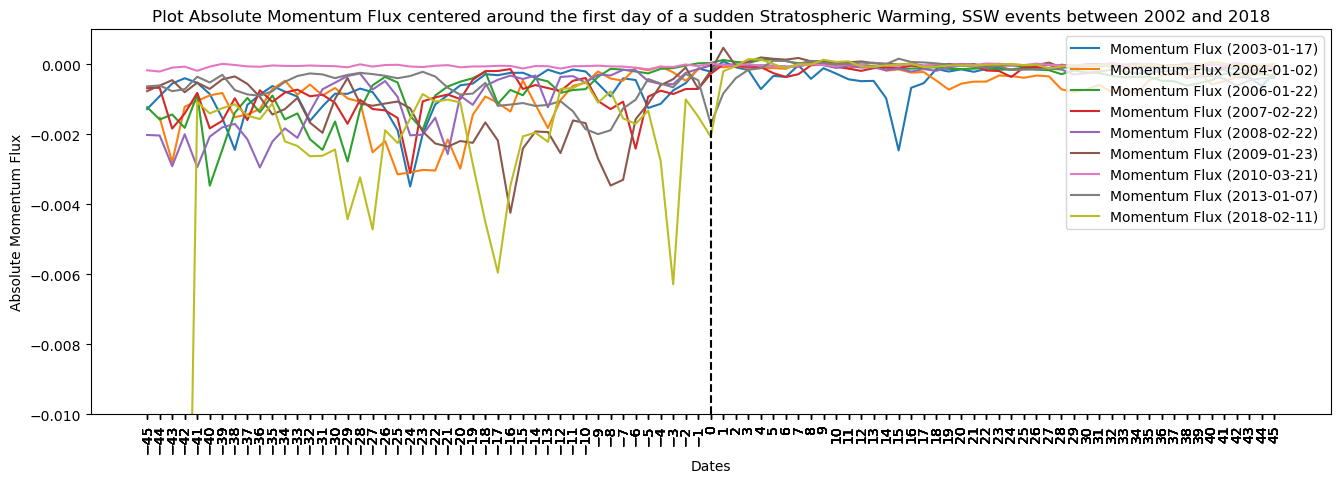

In [150]:
# =================================================================================================
# Plot absolute Momemtum flux with Matplotlib
# =================================================================================================

import matplotlib.pyplot as plt

df = df_all
df_grouped = df.groupby('central_date')
fig, ax1 = plt.subplots(figsize=(16, 5))

for year, dataframe in df_grouped:
    # ax1.plot(dataframe['t_delta'], dataframe['mf_abs'], label=f'Momentum Flux ({year})')
    ax1.plot(dataframe['t_delta'], dataframe['mfx_mean'], label=f'Momentum Flux ({year})')

    
# Set the axis labels and titles
ax1.set_xlabel('Dates')
ax1.set_ylabel('Absolute Momentum Flux')
ax1.set_ylim([-0.01,0.001])
# add ticks for each value in the x axis, every 2nd value
ticks = df['t_delta'][::1]
ax1.set_xticks(ticks)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)

# format the x axis ticks


# add vertical line at t_delta = 0
ax1.axvline(x=0, color='black', linestyle='--')


plt.title('Plot Absolute Momentum Flux centered around the first day of a sudden Stratospheric Warming, SSW events between 2002 and 2018')
plt.legend(loc='upper right')

plt.show()


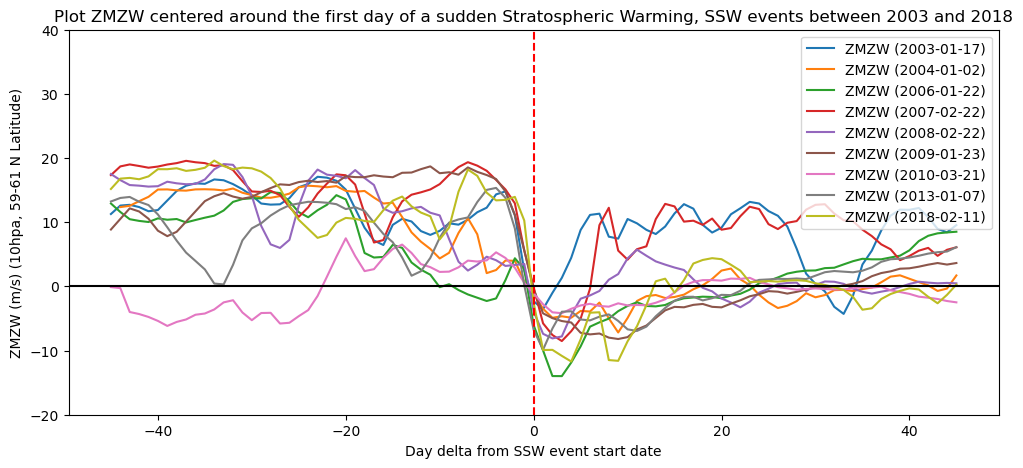

In [151]:
import matplotlib.pyplot as plt

plt.style.use('default')

df = df_all

df_grouped = df.groupby('central_date')

fig, ax1 = plt.subplots(figsize=(12, 5))

for year, dataframe in df_grouped:
    ax1.plot(dataframe['t_delta'], dataframe['wind_eastward_mean_cos'], label=f'ZMZW ({year})')
    
# Set the axis labels and titles
ax1.set_xlabel('Day delta from SSW event start date')
ax1.set_ylabel('ZMZW (m/s) (10hpa, 59-61 N Latitude)')
ax1.set_ylim([-20, 40])
ax1.tick_params(axis='y')

# add vertical line at t_delta = 0
ax1.axvline(x=0, color='red', linestyle='--')

# add horizontal line at y=0
ax1.axhline(y=0, color='black', linestyle='-')

plt.title('Plot ZMZW centered around the first day of a sudden Stratospheric Warming, SSW events between 2003 and 2018')
plt.legend(loc='upper right')

plt.show()


In [152]:
df_all.head(5)

,dates,wind_eastward_mean_cos,SSW_flag,t_delta,central_date,index_,year,mfx_mean,mfy_mean,mfx_mean_zscore,wind_eastward_mean_cos_zscore
0,2002-12-03,11.278949,False,-45,2003-01-17,1,2002,-0.001278,-0.000878,-0.319383,0.672986
1,2002-12-04,12.595781,False,-44,2003-01-17,2,2002,-0.000908,-0.000904,-0.105940,0.840944
2,2002-12-05,12.712304,False,-43,2003-01-17,3,2002,-0.000548,-0.000247,0.101798,0.855806
3,2002-12-06,12.365999,False,-42,2003-01-17,4,2002,-0.000397,0.000196,0.189335,0.811636
4,2002-12-07,11.709422,False,-41,2003-01-17,5,2002,-0.000528,0.000014,0.113651,0.727892


In [153]:
df_all['central_date'].unique()

array(['2003-01-17', '2004-01-02', '2006-01-22', '2007-02-22',
       '2008-02-22', '2009-01-23', '2010-03-21', '2013-01-07',
       '2018-02-11'], dtype=object)

In [168]:
# =================================================================================================
# Plot normalized absolute Momemtum flux and ZMZW with Matplotlib
# =================================================================================================
df_all = df_all[df_all['t_delta'] < 5]

df = df_all
date = '2018-02-11'
df = df[df['central_date'] == date]
# df['mfx_mean_zscore'] = df['mfx_mean'].diff()
# df['wind_eastward_mean_cos_zscore'] = df['mfx_mean'].diff()

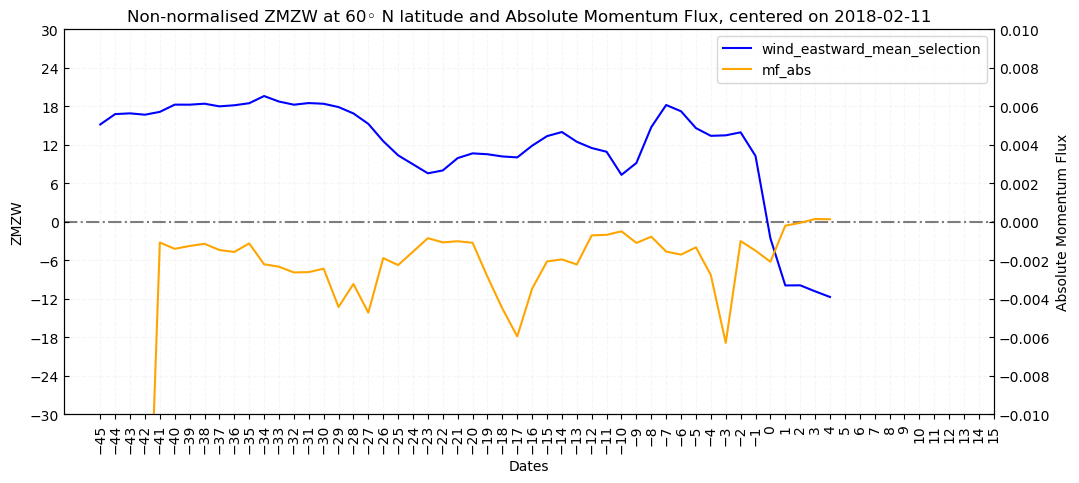

In [169]:


import matplotlib.pyplot as plt

# Plot the data
fig, ax1 = plt.subplots(figsize=(12, 5))

line1, = ax1.plot(df['t_delta'], df['wind_eastward_mean_cos'], color='blue', label='wind_eastward_mean_selection')
ax1.set_xlabel('Dates', color='black')
ax1.set_ylabel('ZMZW', color='black')
ax1.tick_params(axis='y', labelcolor='black', which='both', direction='in')
ax1.set_ylim([-30, 30])
# ax1.set_ylim([-0.01, 0.01])

ax1.grid(axis='both', which='both', linestyle='--', alpha=0.1)

ax2 = ax1.twinx()

line2, = ax2.plot(df['t_delta'], df['mfx_mean'], color='orange', label='mf_abs')
ax2.set_ylabel('Absolute Momentum Flux', color='black')
ax2.tick_params(axis='y', labelcolor='black', which='both', direction='in')
# ax2.set_ylim([-0.01, 0.01])
ax2.set_ylim([-0.01, 0.01])


# add line on y = 0
ax1.axhline(y=0, color='black', linestyle='dashdot', alpha=0.5)
# Increase tick frequency on the x-axis
# set x axis ticks to be every 2nd value
plt.xticks(np.linspace(-45,15,61), rotation = 90)
# rotate x ticks
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)

# Increase tick frequency on the y-axis
ax1.yaxis.set_major_locator(plt.MaxNLocator(10))
ax2.yaxis.set_major_locator(plt.MaxNLocator(10))

# Add title and legend
# plt.title(f'Normalized (z-score) ZMZW at 60◦ N latitude and Absolute Momentum Flux, centered on {date}')
plt.title(f'Non-normalised ZMZW at 60◦ N latitude and Absolute Momentum Flux, centered on {date}')

lines = [line1, line2]
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc='upper right')

plt.show()



In [170]:
# select all values where t_delta is between less thank 15
df_all

,dates,wind_eastward_mean_cos,SSW_flag,t_delta,central_date,index_,year,mfx_mean,mfy_mean,mfx_mean_zscore,wind_eastward_mean_cos_zscore
0,2002-12-03,11.278949,False,-45,2003-01-17,1,2002,-0.001278,-0.000878,-0.319383,0.672986
1,2002-12-04,12.595781,False,-44,2003-01-17,2,2002,-0.000908,-0.000904,-0.105940,0.840944
2,2002-12-05,12.712304,False,-43,2003-01-17,3,2002,-0.000548,-0.000247,0.101798,0.855806
3,2002-12-06,12.365999,False,-42,2003-01-17,4,2002,-0.000397,0.000196,0.189335,0.811636
4,2002-12-07,11.709422,False,-41,2003-01-17,5,2002,-0.000528,0.000014,0.113651,0.727892
...,...,...,...,...,...,...,...,...,...,...,...
785,2018-02-11,-2.573508,True,0,2018-02-11,774,2018,-0.002073,-0.003558,-0.778732,-1.093854
786,2018-02-12,-9.911578,False,1,2018-02-11,775,2018,-0.000198,-0.000445,0.304343,-2.029804
787,2018-02-13,-9.892671,False,2,2018-02-11,776,2018,-0.000052,0.000526,0.388662,-2.027392
788,2018-02-14,-10.827828,False,3,2018-02-11,777,2018,0.000148,-0.000436,0.503899,-2.146669


In [171]:

# =================================================================================================
# Run VAR for absolute momentum flux for ALL SSW events
# =================================================================================================

# Hold self correlation parameters
main_params_df_auto = pd.DataFrame()

# holdc correlation with var parameters
main_params_df_var = pd.DataFrame()

var = 'mfx_mean_zscore'

df_grouped = df_all.groupby('central_date')

for central_date, dataframe in df_grouped:

    for lag in range(1, 15):
        temp_series = dataframe[var].iloc[lag:]
        wind_series = dataframe['wind_eastward_mean_cos'].iloc[:-lag]
        # print('Lag: %s'%lag)
        # print(pearsonr(temp_series, wind_series))
        # print('------')

    dataframe = dataframe[['wind_eastward_mean_cos',var]]
    df['mfx_mean_zscore'] = df['mfx_mean'].diff()
    df['wind_eastward_mean_cos_zscore'] = df['mfx_mean'].diff()
    dataframe = dataframe.reset_index(drop=True)

    model = VAR(dataframe)
    model_fit = model.fit(maxlags=15)
    
    # =================================================================================================
    # Prep df_params for matrix plots
    # =================================================================================================

    df_params = model_fit.params

    # add name to first column in df_params
    df_params =df_params.reset_index()

    # exclude first row from df_params
    df_params = df_params.iloc[1:]

    standard_error = model_fit.pvalues
    # rename column headers in standard_error
    standard_error = standard_error.reset_index()
    standard_error = standard_error.rename(columns={'wind_eastward_mean_cos':'wind_eastward_mean_cos_se',var:f'{var}_se'})
    standard_error = standard_error.iloc[1:]


    # create a new column with the first two characters of index
    df_params['var'] = df_params['index'].str[:3]

    # create a new column with the the characters after the first two characters of index
    df_params['lag'] = df_params['index'].str[3:]

    df_params['var'] = df_params['var'].apply(lambda x: x.strip('.'))
    df_params['lag'] = df_params['lag'].apply(lambda x: x.strip('.'))

    # select only columns lag where it's equal to wind_eastward_mean_cos
    df_params_auto = df_params[df_params['lag'] == 'wind_eastward_mean_cos']
    
    df_params_var = df_params[df_params['lag'] == var]


    df_params_auto['identifier'] = central_date

    df_params_var['identifier'] = central_date


    df_params_auto = pd.merge(df_params_auto, standard_error, on=['index'])

    df_params_var = pd.merge(df_params_var, standard_error, on=['index'])

    # concatenate df_params to main_params_df
    main_params_df_auto = pd.concat([main_params_df_auto, df_params_auto])

    main_params_df_var = pd.concat([main_params_df_var, df_params_var])

In [172]:
# save model_fit.params to csv
params = model_fit.params
params.to_csv('params.csv')


In [173]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 08, May, 2023
Time:                     18:07:21
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -1.37018
Nobs:                     34.0000    HQIC:                  -3.20434
Log likelihood:           36.1224    FPE:                   0.192232
AIC:                     -4.15354    Det(Omega_mle):       0.0525966
--------------------------------------------------------------------
Results for equation wind_eastward_mean_cos
                                coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------------
const                              5.893010         5.768679            1.022           0.307
L1.wind_eastward_mean_cos          1.168181         0.550029            2.124        

In [174]:
# =================================================================================================
# get correlation coeficients for each identifier
# =================================================================================================
param_df = main_params_df_var

coefs_arr = []
for identifier, dataframe in param_df.groupby('identifier'):
    coefs_arr.append(dataframe['wind_eastward_mean_cos'].values)

# =================================================================================================
# get p values for each identifier
# =================================================================================================

coefs_arr_se = []
for identifier, dataframe in param_df.groupby('identifier'):
    coefs_arr_se.append(dataframe['wind_eastward_mean_cos_se'].values)

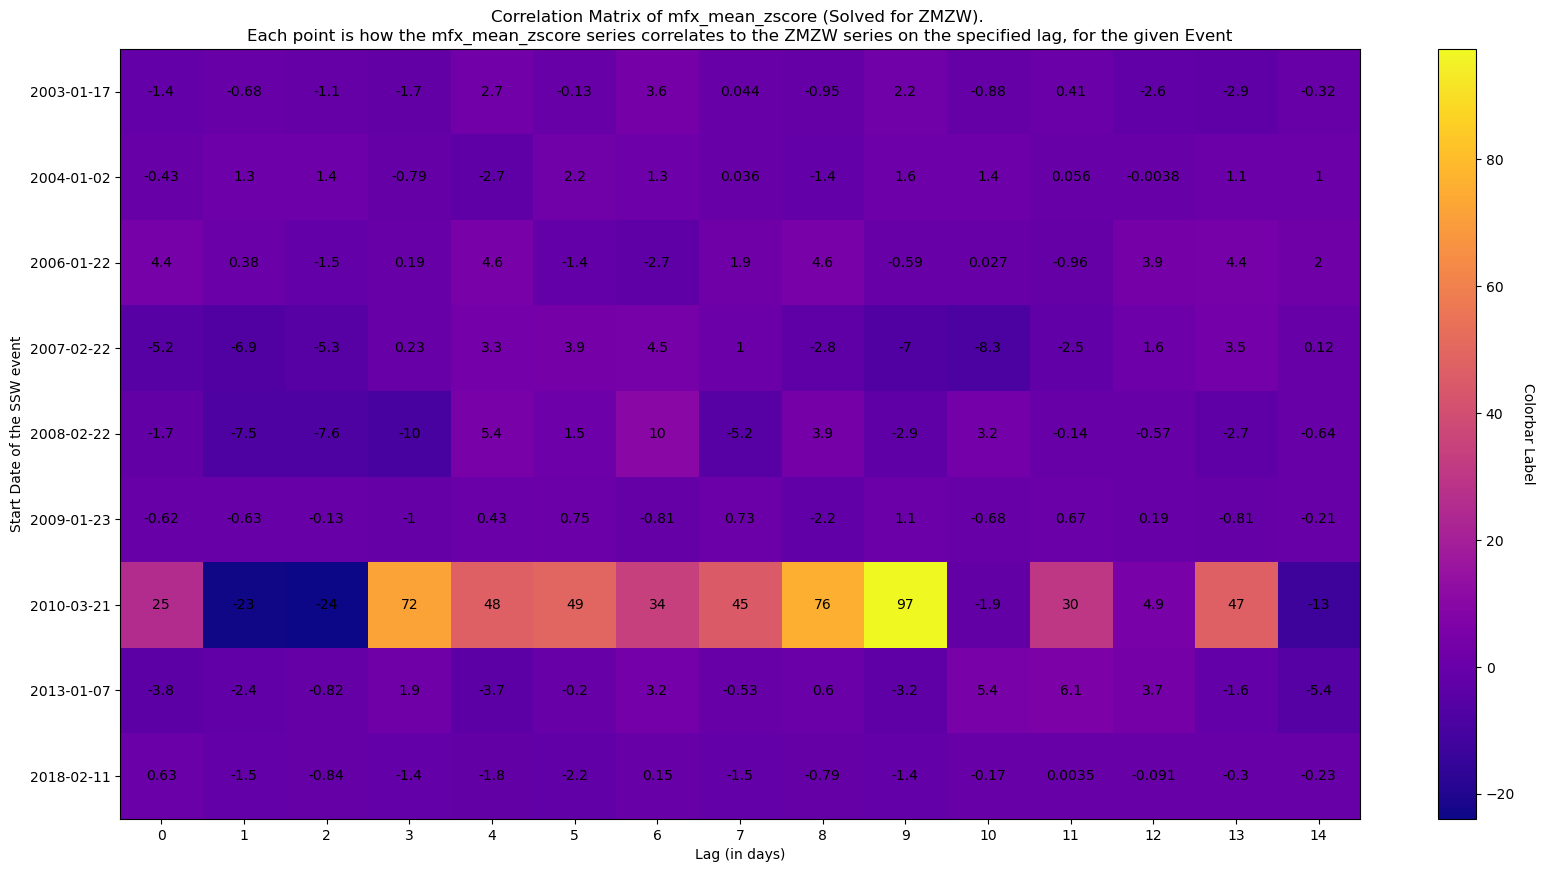

In [175]:
# =================================================================================================
# Plot p values for each identifier (SSW starte date) and lag, using matplotlib
# =================================================================================================

import matplotlib.pyplot as plt
import numpy as np

dates = param_df['identifier'].unique()
dates.sort()

fig, ax = plt.subplots(figsize=(20, 10))
im = ax.imshow(coefs_arr, aspect="auto",cmap='plasma')


# add title to the figure
ax.set_title(f"Correlation Matrix of {var} (Solved for ZMZW). \nEach point is how the {var} series correlates to the ZMZW series on the specified lag, for the given Event")

# Add row labels to the figure
tickvals = np.arange(len(dates))
ax.set_yticks(tickvals)
ax.set_yticklabels(dates)
ax.set_ylabel('Start Date of the SSW event')

ax.set_xticks(np.arange(np.shape(coefs_arr)[1]))
ax.set_xlabel('Lag (in days)')

# add color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Colorbar Label', rotation=-90, va="bottom")

# add numerical values to each box
for i in range(len(dates)):
    for j in range(np.shape(coefs_arr_se)[1]):
        text = ax.text(j, i, "{:.2g}".format(coefs_arr[i][j]),
                       ha="center", va="center", color="black")

plt.show()



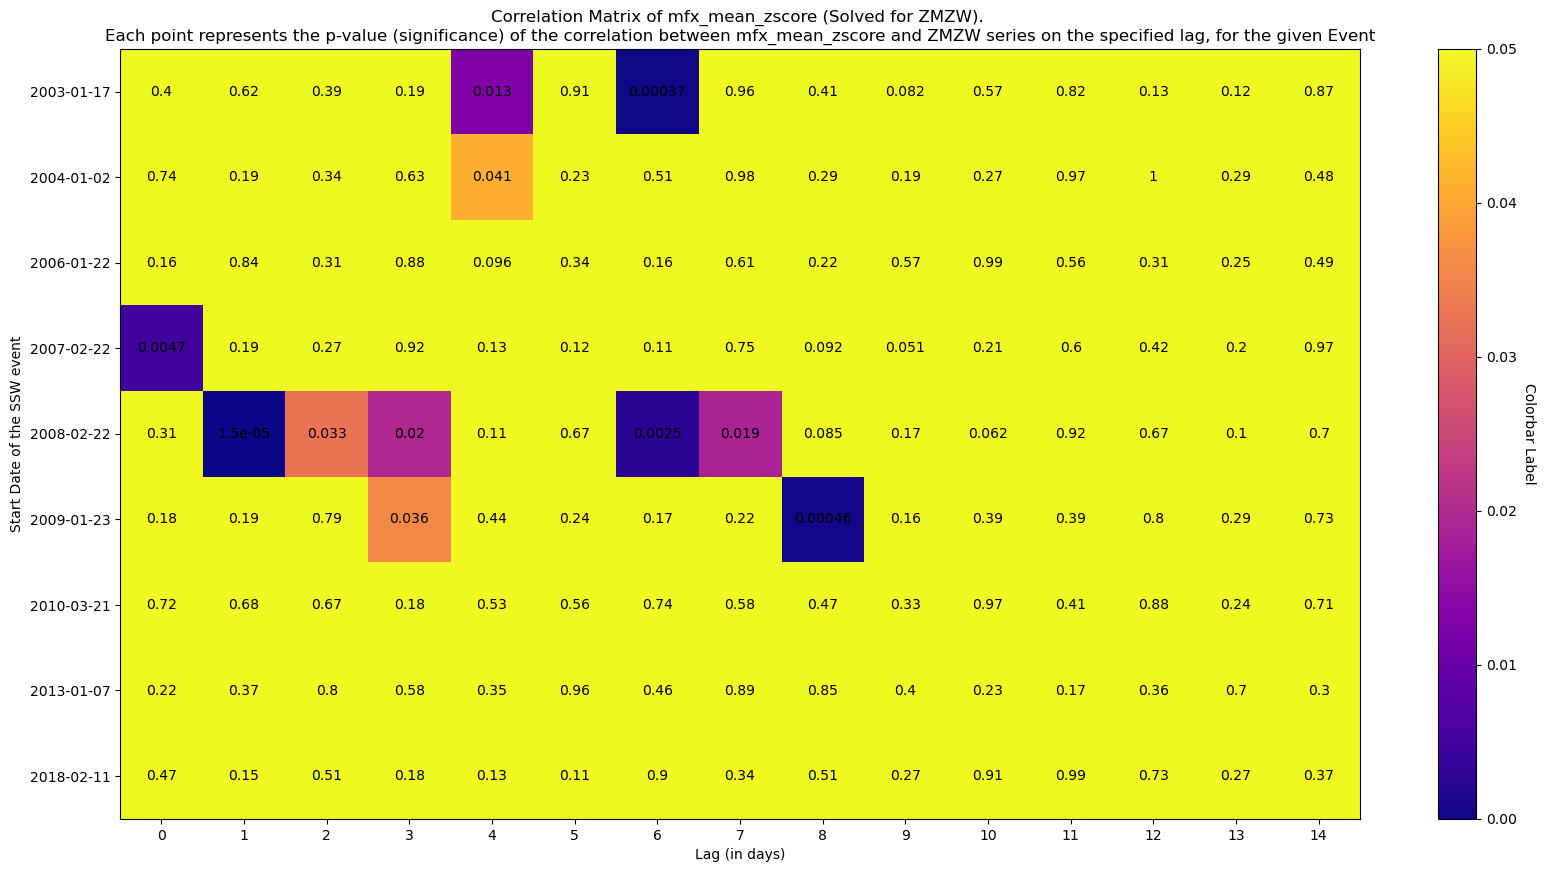

In [176]:
# =================================================================================================
# Plot p values for each identifier (SSW starte date) and lag, using matplotlib
# =================================================================================================

import matplotlib.pyplot as plt
import numpy as np

dates = param_df['identifier'].unique()
dates.sort()

fig, ax = plt.subplots(figsize=(20, 10))
im = ax.imshow(coefs_arr_se, aspect="auto",cmap='plasma')

# set the color gradient
im.set_clim(0, 0.05)

# add title to the figure
ax.set_title(f"Correlation Matrix of {var} (Solved for ZMZW). \nEach point represents the p-value (significance) of the correlation between {var} and ZMZW series on the specified lag, for the given Event")

# Add row labels to the figure
tickvals = np.arange(len(dates))
ax.set_yticks(tickvals)
ax.set_yticklabels(dates)
ax.set_ylabel('Start Date of the SSW event')

ax.set_xticks(np.arange(np.shape(coefs_arr_se)[1]))
ax.set_xlabel('Lag (in days)')

# add color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Colorbar Label', rotation=-90, va="bottom")

# add numerical values to each box
for i in range(len(dates)):
    for j in range(np.shape(coefs_arr_se)[1]):
        text = ax.text(j, i, "{:.2g}".format(coefs_arr_se[i][j]),
                       ha="center", va="center", color="black")

plt.show()

